In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()
warnings.filterwarnings('ignore')

C:\Users\faiza\.conda\envs\signature_verification\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\faiza\.conda\envs\signature_verification\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug,

TensorFlow Version 2.15.0


In [2]:
image_size = 224
batch_size = 16
num_channels = 1  # Change this to 1 for grayscale images

train_path = r'C:\Mine\Work\Uzi\Signature_Verification\train'
val_path = r'C:\Mine\Work\Uzi\Signature_Verification\validation'
test_path = r'C:\Mine\Work\Uzi\Signature_Verification\test'

In [3]:
def data_augment(image):
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)

    # Randomly flip the image vertically
    image = tf.image.random_flip_up_down(image)

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Adding a random brightness change (adjust the max delta as needed)
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Adding a random contrast change (adjust the contrast range as needed)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=False,
    validation_split=0.2,
    preprocessing_function=data_augment
)

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    color_mode='grayscale'  # For grayscale images
)

valid_gen = datagen.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    color_mode='grayscale'  # For grayscale images
)

test_gen = datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    color_mode='grayscale'  # For grayscale images
)

Found 5736 images belonging to 2 classes.
Found 307 images belonging to 2 classes.
Found 1537 images belonging to 2 classes.


In [4]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10

patch_size = 16
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [128, 64]

Model

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation=tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [6]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_size * self.patch_size * num_channels])
        return patches

In [7]:
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units=projection_dim)
        self.position_embedding = L.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [8]:
def vision_transformer():
    inputs = L.Input(shape=(image_size, image_size, num_channels))
    
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = L.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, encoded_patches])
        x3 = L.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = L.Add()([x3, x2])

    representation = L.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = L.Dense(1, activation='sigmoid')(features)
    
    return tf.keras.Model(inputs=inputs, outputs=logits)

In [9]:
decay_steps = train_gen.n // train_gen.batch_size
lr_decayed_fn = tf.keras.experimental.CosineDecay(learning_rate, decay_steps)

model = vision_transformer()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

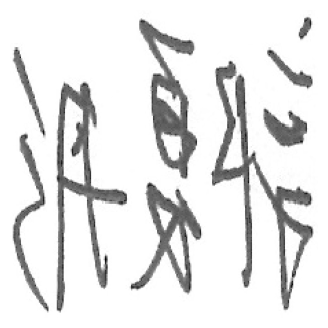


Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 256


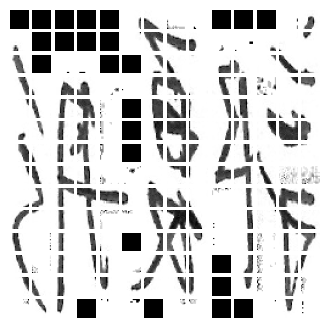

In [9]:
plt.figure(figsize=(4, 4))

x = train_gen.next()
image = x[0][0]

# For grayscale images, you might need to add a color dimension to visualize them correctly
if image.shape[-1] == 1:
    # Convert grayscale to RGB for visualization
    image_vis = np.squeeze(image, axis=-1)
    plt.imshow(image_vis, cmap='gray')
else:
    plt.imshow(image.astype('uint8'))

plt.axis('off')
plt.show()

# Resizing the image to the model's expected input size
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

# Generate patches
patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

# Visualize the patches
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    # Reshape each patch to its original size and visualize
    patch_img = tf.reshape(patch, (patch_size, patch_size, num_channels))
    
    if num_channels == 1:
        plt.imshow(np.squeeze(patch_img.numpy(), axis=-1), cmap='gray')
    else:
        plt.imshow(patch_img.numpy().astype('uint8'))

    plt.axis('off')

plt.show()

In [11]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model.hdf5',
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)

callbacks = [earlystopping, checkpointer]

model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=num_epochs,
    callbacks=callbacks
)

NameError: name 'model' is not defined

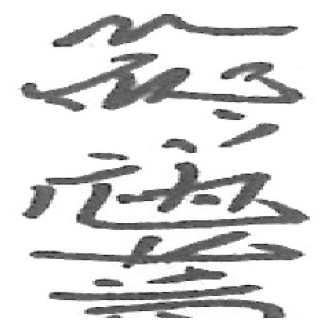

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 256


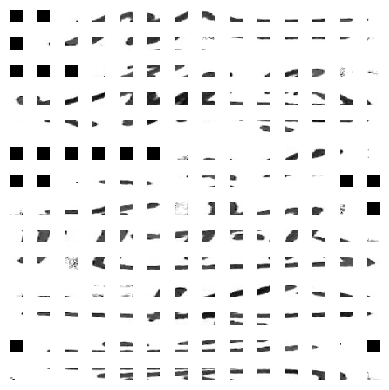

In [11]:
plt.figure(figsize=(4, 4))

x = train_gen.next()
image = x[0][0]

# Display the first image in the batch
if image.shape[-1] == 1:
    # For grayscale images
    plt.imshow(np.squeeze(image, axis=-1), cmap='gray')
else:
    plt.imshow(image.astype('uint8'))
plt.axis('off')
plt.show()

# Generate patches
patches = Patches(patch_size)(tf.convert_to_tensor([image]))

# Calculate the number of patches and patch dimensions
num_patches = patches.shape[1]
patch_dim = patches.shape[-1]

print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {num_patches}')
print(f'Elements per patch: {patch_dim}')

# Visualize the patches
n = int(np.sqrt(num_patches))
plt.figure(figsize=(4, 4))

for i in range(num_patches):
    ax = plt.subplot(n, n, i + 1)
    patch = patches[0, i]
    
    # Reshape the patch
    patch_img = tf.reshape(patch, (patch_size, patch_size, num_channels))
    
    if num_channels == 1:
        plt.imshow(np.squeeze(patch_img.numpy(), axis=-1), cmap='gray')
    else:
        plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [110]:
model_directory = './model_saved'
model.save(model_directory)

INFO:tensorflow:Assets written to: ./model_saved\assets


INFO:tensorflow:Assets written to: ./model_saved\assets


In [10]:
from tensorflow.keras.models import load_model
model_directory = './model_saved'
loaded_model = load_model(model_directory)

In [16]:
for i in test_gen:
    for x in i:
        print(x)

[[[21.471603]
  [21.471603]
  [23.330704]
  ...
  [23.330704]
  [23.330704]
  [22.401154]]

 [[21.471603]
  [19.612503]
  [21.471603]
  ...
  [21.471603]
  [21.471603]
  [20.542053]]

 [[23.330704]
  [21.471603]
  [20.542053]
  ...
  [22.401154]
  [23.330704]
  [23.330704]]

 ...

 [[21.471603]
  [21.471603]
  [22.401154]
  ...
  [23.330704]
  [23.330704]
  [23.330704]]

 [[21.471603]
  [21.471603]
  [22.401154]
  ...
  [23.330704]
  [23.330704]
  [23.330704]]

 [[21.471603]
  [20.542053]
  [22.401154]
  ...
  [23.330704]
  [23.330704]
  [23.330704]]]
[[[40.480026]
  [40.480026]
  [40.480026]
  ...
  [40.480026]
  [40.480026]
  [40.480026]]

 [[40.480026]
  [40.480026]
  [40.480026]
  ...
  [40.480026]
  [40.480026]
  [40.480026]]

 [[40.480026]
  [40.480026]
  [40.480026]
  ...
  [40.480026]
  [40.480026]
  [40.480026]]

 ...

 [[40.480026]
  [40.480026]
  [40.480026]
  ...
  [40.480026]
  [40.480026]
  [40.480026]]

 [[40.480026]
  [40.480026]
  [40.480026]
  ...
  [40.480026]
  [40.

KeyboardInterrupt: 

In [12]:
# Evaluate the model
loss, accuracy = loaded_model.evaluate(test_gen)
print(f"Loss on the test set: {loss}")
print(f"Accuracy on the test set: {accuracy}")


97/97 [==============================] - 18s 184ms/step - loss: 0.5094 - accuracy: 0.8126
Loss on the test set: 0.5093938708305359
Accuracy on the test set: 0.8126220107078552


In [18]:
from sklearn.metrics import accuracy_score, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

def calculate_metrics(labels, scores, far_target=1e-3):
    labels = np.array(labels)
    scores = np.array(scores).flatten()  # Flattening the array if it's 2D with a single column

    # Accuracy
    predictions = (scores > 0.5).astype(int)
    accuracy = accuracy_score(labels, predictions)

    # Calculate ROC Curve and EER
    fpr, tpr, thresholds = roc_curve(labels, scores)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    # Find TAR at specified FAR
    far_index = np.where(fpr <= far_target)[0][-1]
    tar_at_far = tpr[far_index]

    return accuracy, eer, tar_at_far

In [19]:
# Step 1: Generate Predictions and Labels
test_labels = [] # Initialize an empty list for true labels
test_scores = [] # Initialize an empty list for predicted scores

for batch in test_gen:
    images, labels = batch
    scores = loaded_model.predict(images)  # Predict probabilities
    test_scores.extend(scores)
    test_labels.extend(labels)

    if len(test_labels) >= test_gen.n:
        break

# Step 2: Prepare the Data
# Ensure the labels and scores are in the correct format
test_labels = np.array(test_labels)
test_scores = np.array(test_scores)

# Step 3: Calculate the Metrics
accuracy, eer, tar_at_far = calculate_metrics(test_labels, test_scores)

# Print the Results
print(f"Accuracy: {accuracy}")
print(f"EER: {eer}")
print(f"TAR at FAR={1e-3}: {tar_at_far}")


1/1 [==============================] - 0s 271ms/step
Accuracy: 0.8126219908913468
EER: 0.4548611111111112
TAR at FAR=0.001: 0.0


In [20]:
# Print the Results
print(f"Accuracy: {accuracy}")
print(f"EER: {eer}")
print(f"TAR at FAR={1e-3}: {tar_at_far}")

Accuracy: 0.8126219908913468
EER: 0.4548611111111112
TAR at FAR=0.001: 0.0


In [22]:
def list_misclassified_filenames(data_generator, model):
    misclassified_filenames = []
    # Get total number of samples
    total_samples = data_generator.n
    batch_size = data_generator.batch_size

    # Iterate over all batches
    for i in range((total_samples // batch_size) + 1):
        # Load batch
        batch = data_generator.next()
        images, labels = batch

        # Get predictions
        preds = model.predict(images)
        preds = (preds > 0.5).astype(int)  # Convert probabilities to binary predictions

        # Calculate number of images in the current batch (it might be smaller than batch_size for the last batch)
        current_batch_size = len(images)
        
        for j in range(current_batch_size):
            true_label = labels[j]
            pred_label = preds[j]

            # Calculate the correct index in the filepaths list
            current_index = i * batch_size + j
            if current_index < total_samples:
                if pred_label != true_label:
                    # Get the filename from the data generator's filepaths
                    filename = os.path.basename(data_generator.filepaths[current_index])
                    misclassified_filenames.append(filename)

    return misclassified_filenames

# Get the list of misclassified filenames
misclassified_filenames = list_misclassified_filenames(test_gen, loaded_model)

# Optionally, print the list
for filename in misclassified_filenames:
    print(filename)

1/1 [==============================] - 0s 407ms/step
丁会-107-2.jpg
何嘉懿-50-5.jpg
何安福-24-4.jpg
何春-12-3.jpg
何柔煦-20-3.jpg
何柔煦-20-4.jpg
何琇晶-15-3.jpg
何阳曦-30-5.jpg
何高逸-3-2.jpg
余凯乐-33-2.jpg
余娅庭-25-3.jpg
余娅庭-25-5.jpg
余娅庭-30-3.jpg
侯光临-24-2.jpg
公祖舷-50-2.jpg
冯书蕾-28-1.jpg
冯书蕾-67-5.jpg
冯冷卉-69-4.jpg
刘星-28-4.jpg
刘星-50-3.jpg
刘绛-24-1.jpg
刘绛-28-4.jpg
刘鸿波-3-2.jpg
刘鸿波-3-4.jpg
卢俟-24-1.jpg
卢文柏-3-4.jpg
史意远-99-5.jpg
史渺-7-4.jpg
吕钧-24-2.jpg
吕锐阵-36-3.jpg
吴弘伟-24-3.jpg
吴斯年-67-4.jpg
吴濮-69-4.jpg
吴芝芳-30-2.jpg
吴芝芳-43-1.jpg
吴风-3-3.jpg
周乐欣-33-4.jpg
周乐欣-47-3.jpg
周慕灵-97-1.jpg
唐清润-24-1.jpg
唐清润-97-1.jpg
夏娉-25-3.jpg
夏风-33-4.jpg
姚梧桐-99-3.jpg
姚梧桐-99-4.jpg
姚芮-12-2.jpg
姜利-69-5.jpg
姜姜-12-3.jpg
姜子轩-50-3.jpg
姜子轩-50-5.jpg
姜子轩-8-2.jpg
孔典雅-33-1.jpg
孔典雅-33-4.jpg
孔泰华-97-1.jpg
孔瑰玮-52-5.jpg
孔由希-24-1.jpg
孔由希-24-4.jpg
孔由希-24-5.jpg
孔静秀-24-5.jpg
孙正妍-97-4.jpg
孙正妍-99-2.jpg
孟凝海-24-2.jpg
孟凝海-43-1.jpg
孟凝海-50-4.jpg
孟妙-7-3.jpg
孟宇文-15-3.jpg
孟宇文-15-4.jpg
孟鹏鹍-3-5.jpg
宋乐水-36-1.jpg
宋俊达-69-5.jpg
宋含双-43-1.jpg
宋含双-43-4.jpg
尹勇锐-12-1.jpg
尹勇锐-12-3.jpg
尹勇锐-12-4.j

In [23]:
print(len(misclassified_filenames))

273


In [24]:
count = 0
for filename in misclassified_filenames:
    # Split the filename using '-' as a delimiter
    parts = filename.split('-')
    
    # Extract the first part of the split (i.e., the number) and convert it to an integer
    first_number = int(parts[1])
    
    # Check if the first number is greater than 100
    if first_number > 100:
        count += 1

print("Professional Signatures:", count)

Professional Signatures: 1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize_misclassified_samples_with_filenames(data_generator, model, num_images=10, title='Misclassified Samples'):
    misclassified_images, predictions, true_labels, filenames = [], [], [], []
    total_samples = data_generator.n
    batch_size = data_generator.batch_size

    # Iterate over all batches
    for i in range((total_samples // batch_size) + 1):
        # Load batch
        batch = data_generator.next()
        images, labels = batch

        # Get predictions
        preds = model.predict(images)
        preds = (preds > 0.5).astype(int)  # Convert probabilities to binary predictions

        # Calculate number of images in the current batch
        current_batch_size = len(images)
        
        for j in range(current_batch_size):
            true_label = labels[j]
            pred_label = preds[j]

            # Calculate the correct index in the filepaths list
            current_index = i * batch_size + j
            if current_index < total_samples and pred_label != true_label:
                misclassified_images.append(images[j])
                predictions.append(pred_label[0])
                true_labels.append(true_label)
                filenames.append(os.path.basename(data_generator.filepaths[current_index]))

                if len(misclassified_images) == num_images:
                    break
        if len(misclassified_images) == num_images:
            break

    # Plotting
    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 5))
    fig.suptitle(title)
    axes = axes.flatten()
    for i, (img, pred, true, fname) in enumerate(zip(misclassified_images, predictions, true_labels, filenames)):
        if img.shape[-1] == 1:
            # For grayscale images
            img = np.squeeze(img, axis=-1)
            cmap = 'gray'
        else:
            # For RGB images
            cmap = None
        axes[i].imshow(img, cmap=cmap)
        axes[i].axis('off')
        axes[i].set_title(f'File: {fname}\nPred: {pred}, True: {true}')
    plt.tight_layout()
    plt.show()

# Call the function to visualize misclassified samples with filenames
visualize_misclassified_samples_with_filenames(test_gen, loaded_model)